<a href="https://colab.research.google.com/github/ldsad7/Sentiment_Analysis_rusdracor/blob/master/tonality_survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
import os
import json
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging._warn_preinit_stderr = 0
import multiprocessing
import gensim
import re
import csv
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

import html as html_
import pandas as pd
import numpy as np
np.random.seed(21)
import seaborn as sns
from keras import backend as K

from collections import defaultdict, Counter, OrderedDict
from matplotlib import pyplot as plt
from lxml import etree
from xml.etree import ElementTree as ET
from copy import deepcopy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras import optimizers
from keras.utils import to_categorical, np_utils
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, concatenate, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
path_to_drive = '/content/drive/My Drive/'
path_to_utils = '/content/drive/My Drive/utils'

# Extracting the texts from tei plays

In [0]:
def extract_replicas(input_file, output_file, save_speakers=False, save_parents=False):
    if save_speakers:
        speakers_file = open(os.path.join(path_to_utils, 'speakers.txt'), 'w', encoding='utf-8')
    if save_parents:
        parents_file = open(os.path.join(path_to_utils, 'parents.txt'), 'w', encoding='utf-8')
    parser = etree.XMLParser(remove_comments=True, remove_blank_text=True)
    root = etree.fromstring(input_file.read().encode('utf-8'), parser=parser)
    # strip all namespaces
    for tag in root.iter():
        try:
            if '}' in tag.tag:
                tag.tag = tag.tag.split('}', 1)[1]
        except TypeError:
            continue
    for sp in root.xpath('//sp'):
        children = sp.getchildren()
        text = ''
        for child in children:  # skip speaker
            if child.tag == 'speaker':
                continue
            for inner_child in child.iter():
                if inner_child.tag in ['p', 'l']:
                    for inner_inner_child in inner_child.iter():
                        if inner_inner_child.tag != 'stage' and inner_inner_child.text is not None:
                            text += inner_inner_child.text.strip() + ' '
                        if inner_inner_child.tail is not None:
                            text += inner_inner_child.tail.strip() + ' '
                elif inner_child.tag == 'stage':
                    if text:
                        text = re.sub('\s+', ' ', text.strip())
                        text = re.sub(r'\s([.,?!])', r'\1', text)
                        if save_speakers:
                            speakers_file.write(sp.attrib['who'] + '\n')
                        if save_parents:
                            parent = sp.getparent()
                            parent_of_parent = parent.getparent()
                            parents_file.write(parent_of_parent.getchildren()[0].text + ' ' + parent.getchildren()[0].text + '\n')
                        output_file.write(text + '\n')
                    text = ''
                    if inner_child.tail is not None:
                        text += inner_child.tail.strip() + ' '
        text = re.sub('\s+', ' ', text.strip())
        text = re.sub(r'\s([.,?!])', r'\1', text)
        if text:
            if save_speakers:
                speakers_file.write(sp.attrib['who'] + '\n')
            if save_parents:
                parent = sp.getparent()
                parent_of_parent = parent.getparent()
                parents_file.write(parent_of_parent.getchildren()[0].text + ' ' + parent.getchildren()[0].text + '\n')
            output_file.write(text + '\n')
    if save_speakers:
        speakers_file.close()
    if save_parents:
        parents_file.close()

In [0]:
with open(os.path.join(path_to_drive, 'utils', 'replicas.txt'), 'w', encoding='utf-8') as output_file:
    for file in os.listdir(os.path.join(path_to_drive, 'tei')):
        # print(file)
        with open(os.path.join(path_to_drive, 'tei', file), 'r', encoding='utf-8') as input_file:
            extract_replicas(input_file, output_file)

In [0]:
with open(os.path.join(path_to_drive, 'utils', 'gore_ot_uma.txt'), 'w', encoding='utf-8') as output_file:
    with open(os.path.join(path_to_drive, 'tei', 'griboyedov-gore-ot-uma.xml'), 'r', encoding='utf-8') as input_file:
        extract_replicas(input_file, output_file)

# train and test data

1) Tweets (Rubtsova): https://study.mokoron.com/

In [0]:
path_to_tweets = '/content/drive/My Drive/Tweets'

In [0]:
fields = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv(os.path.join(path_to_tweets, 'positive.csv'), sep=';', error_bad_lines=False, names=fields, usecols=['text', 'type'])
data_negative = pd.read_csv(os.path.join(path_to_tweets, 'negative.csv'), sep=';', error_bad_lines=False, names=fields, usecols=['text', 'type'])
# with open(os.path.join(path_to_tweets, 'neutral.json'), 'r', encoding='utf-8') as f:
#     data_neutral = json.load(f)
# data_neutral = pd.DataFrame({'text': data_neutral, 'type': [0] * len(data_neutral)})

In [46]:
data_positive.shape, data_negative.shape

((114911, 2), (111923, 2))

In [0]:
raw_data = pd.concat((data_positive, data_negative), axis=0, ignore_index=True)
# todo try later
# raw_data = np.concatenate((data_positive, data_neutral, data_negative), axis=0)

2) Sentiment Analysis in Russian (Kaggle competition): https://www.kaggle.com/c/sentiment-analysis-in-russian/data

In [0]:
with open(os.path.join(path_to_utils, 'train.json'), 'r', encoding='utf-8') as f:
    news = json.load(f)

In [0]:
news_df = pd.DataFrame(news)
news_df.rename(columns={'sentiment': 'type'}, inplace=True)
del news_df['id']

In [0]:
news_df['type'] = news_df['type'].map({'negative': -1, 'neutral': 0, 'positive': 1})

In [0]:
raw_data = pd.concat((raw_data, news_df), axis=0, ignore_index=True, sort=False)

3) SentiStrength dataset of Russian tweets: http://sentistrength.wlv.ac.uk/

In [0]:
with open(os.path.join(path_to_utils, 'RussianTweets3972.txt'), 'r', encoding='utf-8') as f:
    tweets = [elem.split('\t') for elem in f.read().split('\n')[1:]]

In [0]:
tweets_df = pd.DataFrame(tweets[:10], columns=['positive', 'negative', 'text'])

In [0]:
def sentiment_condition(row):
    if int(float(row['positive'])) - int(float(row['negative'])) >= 2:
        return 1
    elif int(float(row['positive'])) - int(float(row['negative'])) <= -2:
        return -1
    else:
        return 0

In [0]:
tweets_df['type'] = tweets_df.apply(sentiment_condition, axis=1)
del tweets_df['positive']
del tweets_df['negative']

In [0]:
raw_data = pd.concat((raw_data, tweets_df), axis=0, ignore_index=True, sort=False)

4) RuSentiment: http://text-machine.cs.uml.edu/projects/rusentiment/ (dataset is actually here: https://gitlab.com/kensand/rusentiment/tree/master/Dataset)

In [0]:
def convert_sentiment_to_number(line):
    if line.startswith('negative'):
        return -1
    elif line.startswith('neutral'):
        return 0
    else:
        return 1

In [0]:
vk_posts = []
sentiments = []
for file in ['Dataset_rusentiment_preselected_posts.csv', 'Dataset_rusentiment_random_posts.csv', 'Dataset_rusentiment_test.csv']:
    with open(os.path.join(path_to_utils, file), 'r', encoding='utf-8') as f:
        text = ''
        sentiment = None
        fl = None
        for line in f.readlines()[1:]:
            if line.startswith(('negative', 'neutral', 'positive', 'skip', 'speech')) and (text.strip() or fl is None):
                fl = 0
                if line.startswith(('negative', 'neutral', 'positive')):
                    if text.strip():
                        vk_posts.append(text.strip())
                        sentiments.append(sentiment)
                    text = line.split(',', maxsplit=1)[1].strip() + ' '
                    sentiment = convert_sentiment_to_number(line)
                    fl = 1
            elif fl:
                text += line.strip() + ' '
        if text.strip():
            vk_posts.append(text.strip())
            sentiments.append(sentiment)

In [0]:
raw_data = pd.concat((raw_data, pd.DataFrame({'text': vk_posts, 'type': sentiments})), axis=0, ignore_index=True, sort=False)

5) Crowdsourcing platform for sentiment analysis: http://linis-crowd.org/

In [0]:
texts_to_grades = defaultdict(list)

for file in ['text_rating_final.txt', 'doc_comment_summary.txt']:
    with open(os.path.join(path_to_utils, file), 'r', encoding='utf-8') as f:
        for line in f.readlines():
            try:
                text, grade = line.rsplit(maxsplit=1)
                texts_to_grades[text.strip()].append(int(float(grade)))
            except ValueError:
                del texts_to_grades[text.strip()]

In [0]:
texts = list(texts_to_grades.keys())
grades = []
for text in texts:
    grade = int(float(round(np.mean(texts_to_grades[text]))))
    if grade <= -1:
        grades.append(-1)
    elif grade >= 1:
        grades.append(1)
    else:
        grades.append(0)

In [0]:
raw_data = pd.concat((raw_data, pd.DataFrame({'text': texts, 'type': grades})), axis=0, ignore_index=True, sort=False)

In total:

In [64]:
raw_data.shape

(294032, 2)

In [65]:
Counter(raw_data['type'])

Counter({-1: 129831, 0: 37660, 1: 126541})

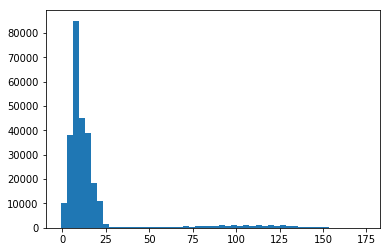

In [66]:
plt.hist([len(text.split()) for text in raw_data['text'] if len(text) < 1000], align='left', bins=50)
plt.show()

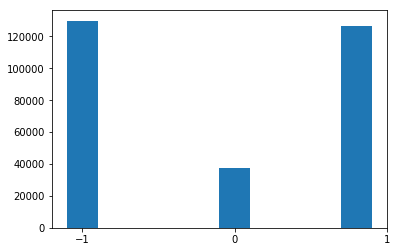

In [67]:
plt.hist(raw_data['type'], align='left')
plt.xticks([-1, 0, 1])
plt.show()

In [68]:
max_size = Counter(raw_data['type'])[0]
print(max_size)

37660


In [0]:
negative = raw_data.loc[raw_data['type'] == -1].sample(frac=1, random_state=21)[:max_size]
neutral = raw_data.loc[raw_data['type'] == 0].sample(frac=1, random_state=21)[:max_size]
positive = raw_data.loc[raw_data['type'] == 1].sample(frac=1, random_state=21)[:max_size]

In [0]:
train_data = pd.concat((negative, neutral, positive), axis=0, ignore_index=True, sort=False).sample(frac=1)

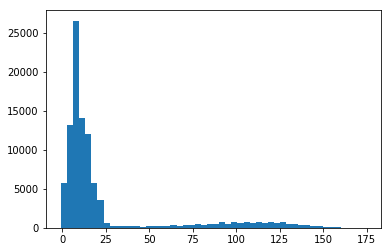

In [71]:
plt.hist([len(text.split()) for text in train_data['text'] if len(text) < 1000], align='left', bins=50)
plt.show()

Test data ("Woe from Wit" / "Gore Ot Uma" by Aleksander Griboyedov):

In [0]:
texts = []
grades = []
with open(os.path.join(path_to_utils, 'gore_ot_uma_grades.txt'), 'r', encoding='utf-8') as f:
    for line in f.readlines():
        text, grade = line.rsplit('    ')
        texts.append(text.strip())
        grades.append(int(float(grade)))

In [0]:
test_df = pd.DataFrame({'text': texts, 'type': grades})

In [74]:
Counter(test_df['type'])

Counter({-1: 187, 0: 434, 1: 127})

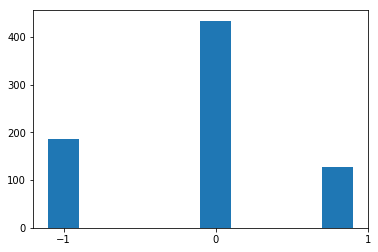

In [75]:
plt.hist(test_df['type'], align='left')
plt.xticks([-1, 0, 1])
plt.show()

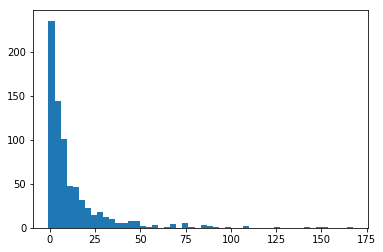

In [76]:
plt.hist([len(text.split()) for text in test_df['text'] if len(text) < 1000], align='left', bins=50)
plt.show()

Dataset on the whole:

In [0]:
texts = []
with open(os.path.join(path_to_utils, 'replicas.txt'), 'r', encoding='utf-8') as f:
    for line in f.readlines():
        texts.append(line)

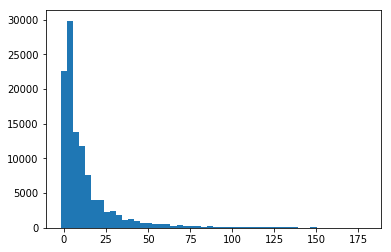

In [78]:
plt.hist([len(text.split()) for text in texts if len(text) < 1000], align='left', bins=50)
plt.show()

Similar plots though. Maybe tweets are not so bad in a manner.

# Experiments

In [0]:
def preprocess_text(text):

    # remove urls
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)

    # remove users
    text = re.sub('@[^\s]+', ' ', text)

    # remove smiles
    # see https://stackoverflow.com/questions/28077049/regex-matching-emoticons
    text = re.sub('(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)', ' ', text)

    # leave only letters
    text = re.sub('[^a-zA-Zа-яёА-ЯЁ\s]+', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()

In [0]:
train_data['text'] = [preprocess_text(text) for text in train_data['text']]

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_data['text'], train_data['type'], test_size=0.2, random_state=21)

In [82]:
x_train.shape, x_test.shape

((90384,), (22596,))

In [0]:
with open(os.path.join(path_to_utils, 'texts_processed.txt'), 'w', encoding='utf-8') as f:
    [f.write(preprocess_text(text) + '\n') for text in raw_data['text']]
    with open(os.path.join(path_to_drive, 'utils', 'replicas.txt'), 'r', encoding='utf-8') as input_file:
        f.write(input_file.read())
    with open(os.path.join(path_to_tweets, 'tweets.txt'), 'r', encoding='utf-8') as input_file:
        f.write(input_file.read())
# 343 MB

In [0]:
SENTENCE_LENGTH = 30
DICT_SIZE = 1000000
DIM = 200
CLASSES = 3

In [0]:
# vectors
data = gensim.models.word2vec.LineSentence(os.path.join(path_to_utils, 'texts_processed.txt'))
model = Word2Vec(data, size=DIM, window=5, min_count=3)
model.save(os.path.join(path_to_utils, "model.w2v"))

In [0]:
def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

In [0]:
tokenizer = Tokenizer(num_words=DICT_SIZE)
tokenizer.fit_on_texts(x_train)

In [0]:
x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [0]:
w2v_model = Word2Vec.load(os.path.join(path_to_utils, "model.w2v"))

In [0]:
embedding_matrix = np.zeros((DICT_SIZE, DIM))

In [0]:
for word, i in tokenizer.word_index.items():
    if i >= DICT_SIZE:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

In [0]:
inputs = [Input(shape=(SENTENCE_LENGTH,), dtype='int32')]

In [0]:
inputs[0]

In [0]:
model = Sequential()
model.add(Embedding(DICT_SIZE, DIM, input_length=SENTENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(512, CLASSES, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(256, CLASSES, activation='relu'))
model.add(Flatten())
model.add(Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [170]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 200)           200000000 
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 28, 512)           307712    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 14, 512)           0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 12, 256)           393472    
_________________________________________________________________
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 9219      
Total params: 200,710,403
Trainable params: 710,403
Non-trainable params: 200,000,000
________________________________________________________

In [0]:
le = LabelEncoder()
classes = y_train.unique()
le.fit(classes)
y_formatted_train = np_utils.to_categorical(le.transform(y_train), CLASSES)
y_formatted_test = np_utils.to_categorical(le.transform(y_test), CLASSES)

In [0]:
model.fit(x_train_seq, y_formatted_train, batch_size=32, epochs=100, validation_split=0.25)

In [0]:
labels=['negative', 'neutral', 'positive']

def get_cm(X, y):
    predictions = []
    for index, row in X.iterrows():
        predictions.append(rules(set(row['lowered_words'])))
    cm = confusion_matrix(y, predictions, labels)
    return cm

def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True);

def print_metrics_from_cm(cm):
    precisions = np.diag(cm) / np.sum(cm, axis=0)
    recalls = np.diag(cm) / np.sum(cm, axis=1)
    mean_precision = np.mean(precisions)
    print("Mean Precision:", mean_precision)
    mean_recall = np.mean(recalls)
    print("Mean Recall", mean_recall)
    print("Accuracy:", np.sum(np.diag(cm)) / np.sum(cm))
    print("F1 score:", 2 * mean_precision * mean_recall / (mean_precision + mean_recall))

In [0]:
y_pred = model.predict_classes(x_test_seq)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.6362923284170514
Mean Recall 0.6366451207998409
Accuracy: 0.6376792352628784
F1 score: 0.636468675720551


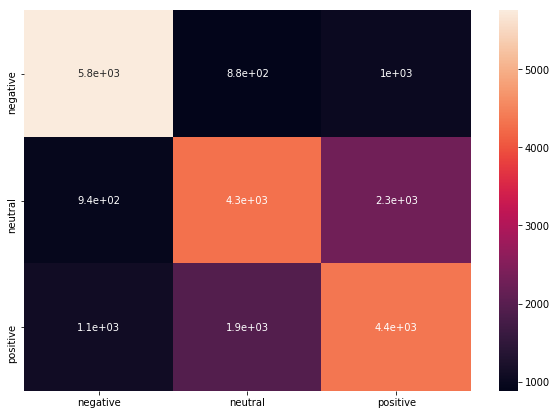

In [174]:
cm = confusion_matrix(y_test, predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

In [176]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

          -1    0.56849   0.58866   0.57840      7410
           0    0.73747   0.74958   0.74347      7675
           1    0.60292   0.57169   0.58689      7511

    accuracy                        0.63768     22596
   macro avg    0.63629   0.63665   0.63626     22596
weighted avg    0.63733   0.63768   0.63729     22596



In [0]:
test_df['text'] = [preprocess_text(text) for text in test_df['text']]

In [0]:
x_test_seq = get_sequences(tokenizer, test_df['text'])

In [0]:
y_pred = model.predict_classes(x_test_seq)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.3721586648367751
Mean Recall 0.386509636528313
Accuracy: 0.3917112299465241
F1 score: 0.37919841917239616


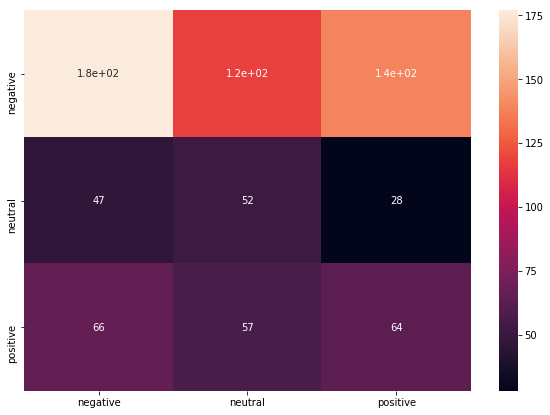

In [191]:
cm = confusion_matrix(test_df['type'], predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

In [193]:
print(classification_report(test_df['type'], predictions, digits=5))

              precision    recall  f1-score   support

          -1    0.27706   0.34225   0.30622       187
           0    0.61034   0.40783   0.48895       434
           1    0.22907   0.40945   0.29379       127

    accuracy                        0.39171       748
   macro avg    0.37216   0.38651   0.36299       748
weighted avg    0.46229   0.39171   0.41013       748



In [200]:
for a, b in zip(test_df['type'][-10:], test_df['text'][-10:]):
    print(a, b)

-1 Скорее в обморок теперь оно в порядке Важнее давишной причина есть тому Вот наконец решение загадке Вот я пожертвован кому Не знаю как в себе я бешенство умерил Глядел и видел и не верил А милый для кого забыт И прежний друг и женский страх и стыд За двери прячется боится быть в ответе Ах как игру судьбы постичь Людей с душой гонительница бич Молчалины блаженствуют на свете
-1 Не продолжайте я виню себя кругом Но кто бы думать мог чтоб был он так коварен
-1 Стук шум ах боже мой сюда бежит весь дом Ваш батюшка вот будет благодарен
-1 Сюда за мной скорей скорей Свечей побольше фонарей Где домовые Ба знакомые всё лица Дочь Софья Павловна страмница Бесстыдница где с кем Ни дать ни взять она Как мать ее покойница жена Бывало я с дражайшей половиной Чуть врознь уж где нибудь с мужчиной Побойся бога как чем он тебя прельстил Сама его безумным называла Нет глупость на меня и слепота напала Все это заговор и в заговоре был Он сам и гости все За что я так наказан
-1 Так этим вымыслом я вам ещ

In [201]:
for a, b in zip(predictions[-10:], test_df['text'][-10:]):
    print(a, b)

0 Скорее в обморок теперь оно в порядке Важнее давишной причина есть тому Вот наконец решение загадке Вот я пожертвован кому Не знаю как в себе я бешенство умерил Глядел и видел и не верил А милый для кого забыт И прежний друг и женский страх и стыд За двери прячется боится быть в ответе Ах как игру судьбы постичь Людей с душой гонительница бич Молчалины блаженствуют на свете
-1 Не продолжайте я виню себя кругом Но кто бы думать мог чтоб был он так коварен
1 Стук шум ах боже мой сюда бежит весь дом Ваш батюшка вот будет благодарен
0 Сюда за мной скорей скорей Свечей побольше фонарей Где домовые Ба знакомые всё лица Дочь Софья Павловна страмница Бесстыдница где с кем Ни дать ни взять она Как мать ее покойница жена Бывало я с дражайшей половиной Чуть врознь уж где нибудь с мужчиной Побойся бога как чем он тебя прельстил Сама его безумным называла Нет глупость на меня и слепота напала Все это заговор и в заговоре был Он сам и гости все За что я так наказан
0 Так этим вымыслом я вам еще об

Plot example

In [0]:
with open(os.path.join(path_to_drive, 'utils', 'ostrovsky-svoi-ljudi.txt'), 'w', encoding='utf-8') as output_file:
    with open(os.path.join(path_to_drive, 'tei', 'ostrovsky-svoi-ljudi.xml'), 'r', encoding='utf-8') as input_file:
        extract_replicas(input_file, output_file, save_speakers=True, save_parents=True)

In [0]:
with open(os.path.join(path_to_utils, 'ostrovsky-svoi-ljudi.txt'), 'r', encoding='utf-8') as f:
    x_test_seq = get_sequences(tokenizer, f.read().split('\n'))
    y_pred = model.predict_classes(x_test_seq)
    predictions = le.inverse_transform(y_pred)
with open(os.path.join(path_to_utils, 'speakers.txt'), 'r', encoding='utf-8') as f:
    speakers = f.read().split('\n')
with open(os.path.join(path_to_utils, 'parents.txt'), 'r', encoding='utf-8') as f:
    parents = f.read().split('\n')

In [303]:
len(predictions), len(speakers), len(parents)

(946, 946, 946)

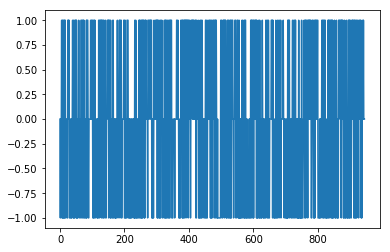

In [304]:
# doesn't make any sense...
# it should be better when I will predict a float number, not a class
plt.plot(predictions)
plt.show()

In [0]:
speaker_to_predictions = defaultdict(list)
parent_to_predictions = OrderedDict()
for prediction, speaker, parent in zip(predictions, speakers, parents):
    speaker_to_predictions[speaker].append(prediction)
    if parent in parent_to_predictions:
        parent_to_predictions[parent].append(prediction)
    else:
        parent_to_predictions[parent] = [prediction]

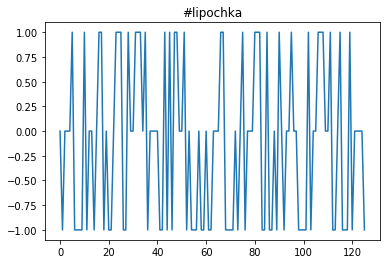

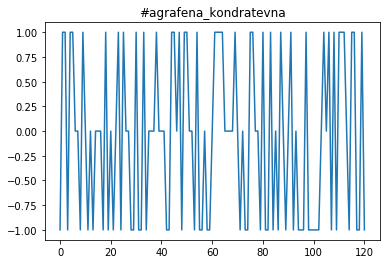

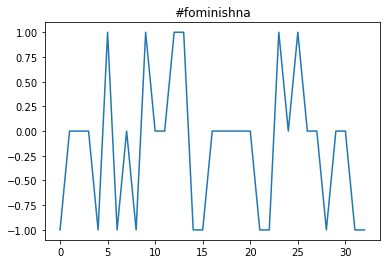

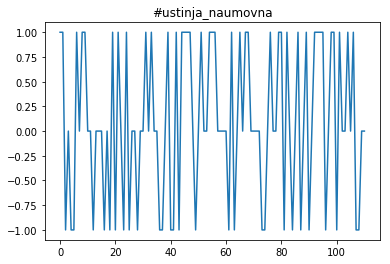

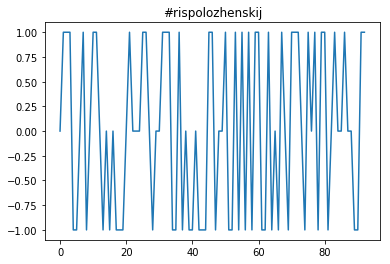

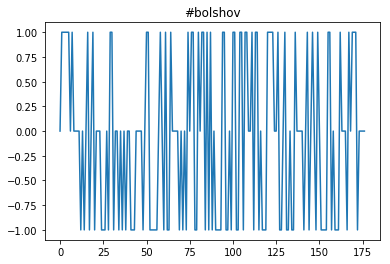

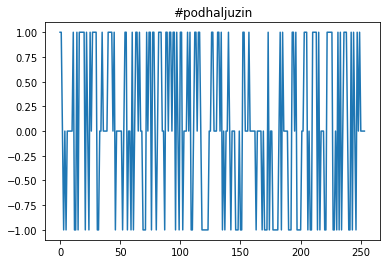

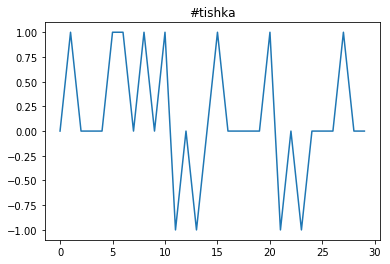

In [306]:
for speaker, predictions in speaker_to_predictions.items():
    if not speaker:
        continue
    plt.title(speaker)
    plt.plot(predictions)
    plt.show()

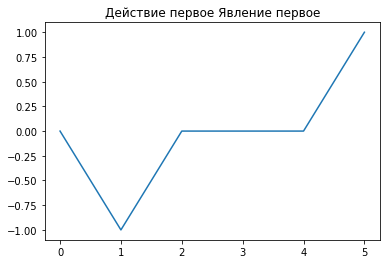

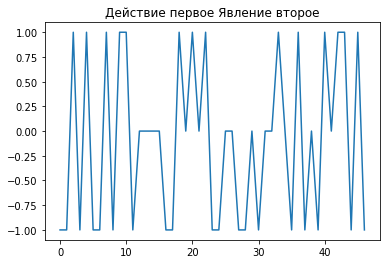

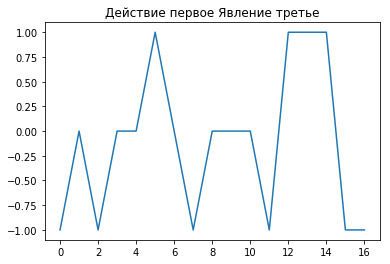

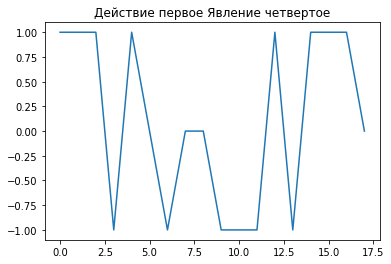

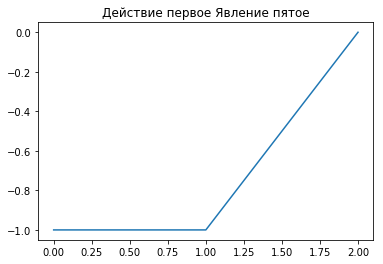

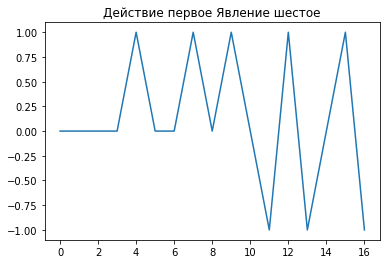

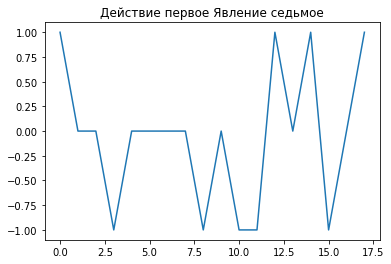

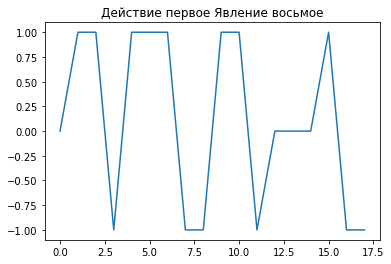

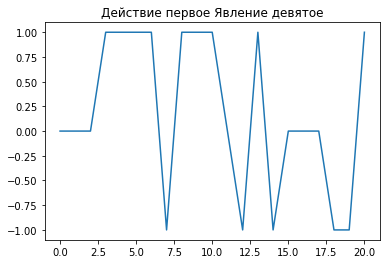

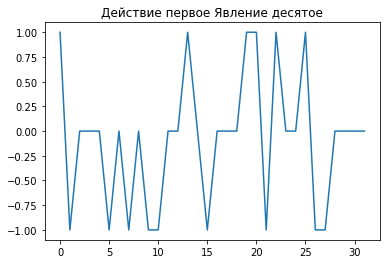

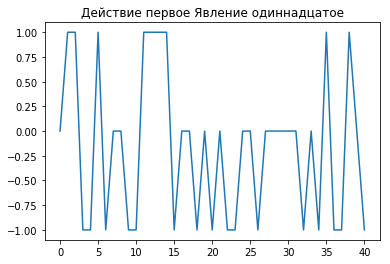

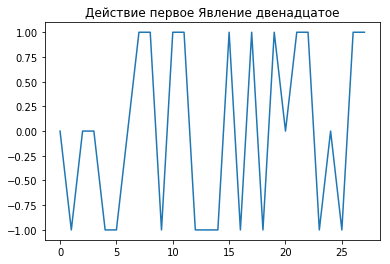

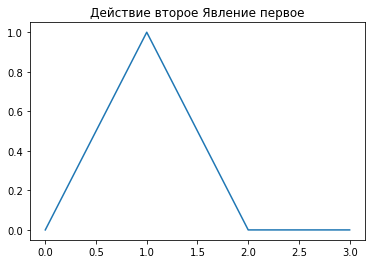

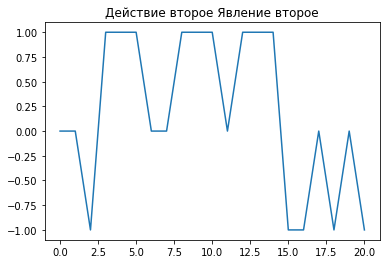

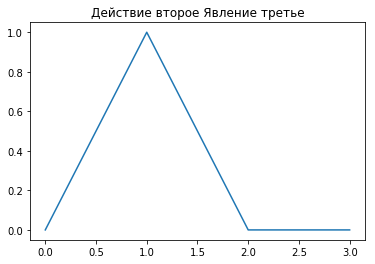

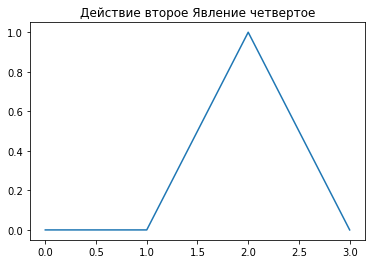

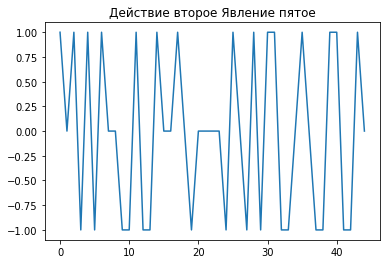

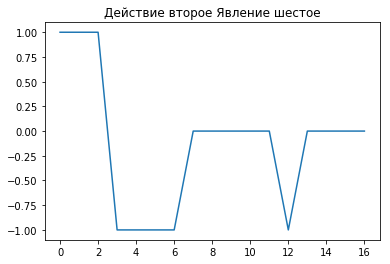

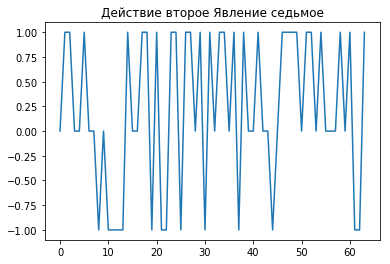

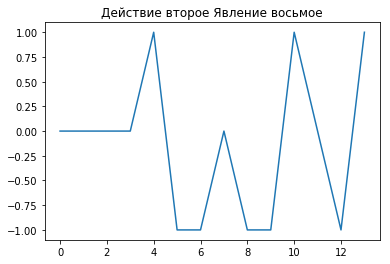

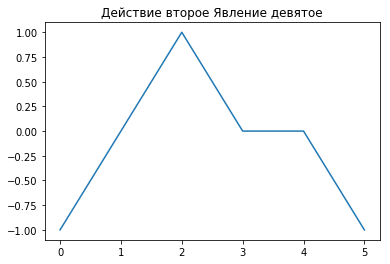

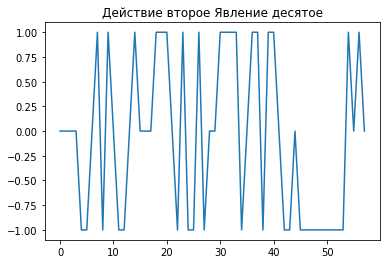

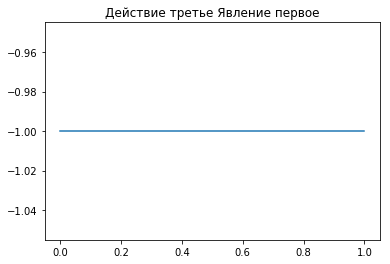

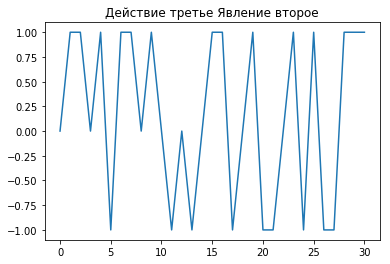

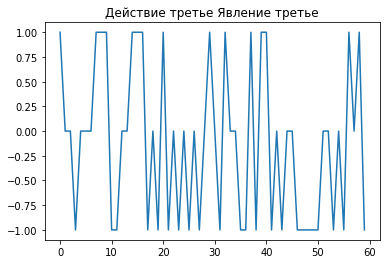

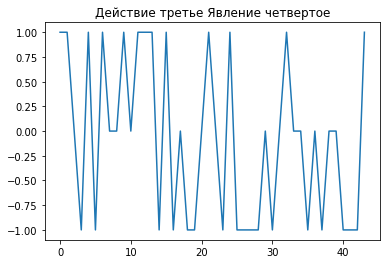

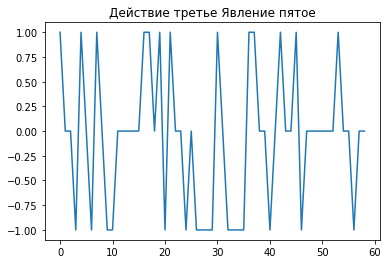

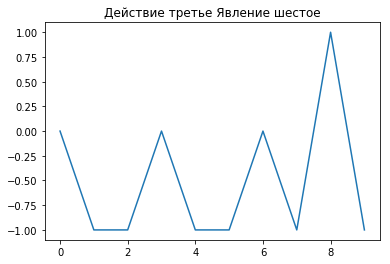

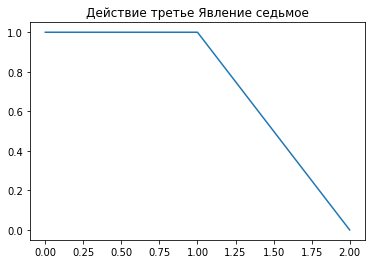

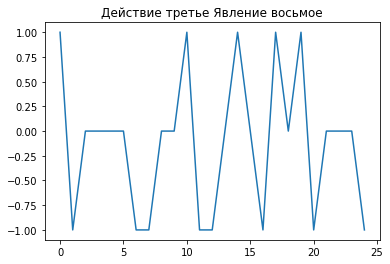

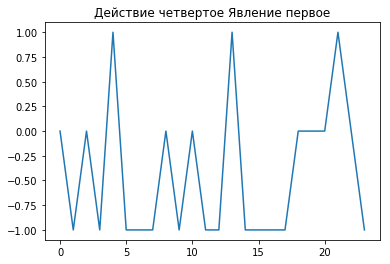

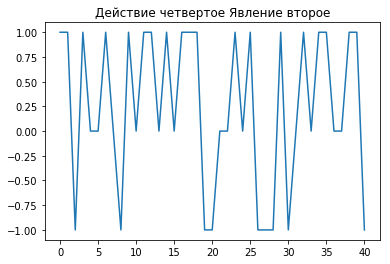

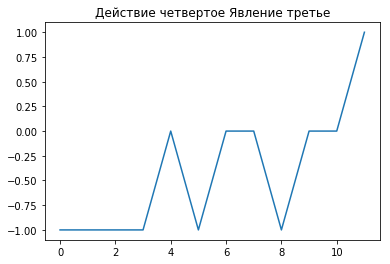

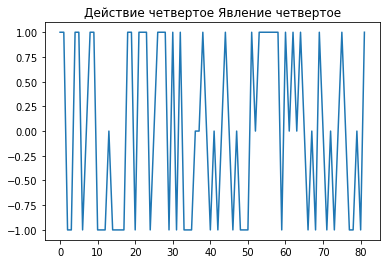

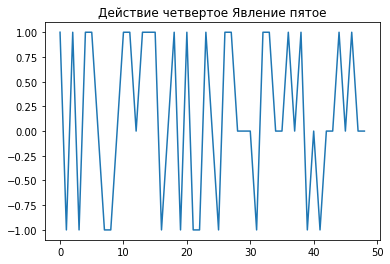

In [307]:
for parent, predictions in parent_to_predictions.items():
    if not parent:
        continue
    plt.title(parent)
    plt.plot(predictions)
    plt.show()

In [0]:
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib
# https://stackoverflow.com/questions/54965009/grouped-x-axis-variability-plot-in-python

Guidelines при аннотации: https://github.com/text-machine-lab/rusentiment/blob/master/Guidelines/guidelines_%5BEN%5D.md

1) Мы будем размечать разного рода приветствия, поздравления и благодарности скорее как позитивный класс, поскольку мы в нашем случае хотим размечать явную тональность, а не скрытую. Также мы не всегда можем адекватно оценить, когда человек приветствует и благодарит из-за социального давления, а когда от сердца. Проблема возникает с разного рода иронией, сарказмом и т.д. Позитивный или негативный класс? В нашем случае мы хотим и размечать ещё и потому, что поздравления в пьесах в принципе не так частотны, поэтому скорее несут позитивный заряд.

2) Хотим ли мы как-то различать смешанные эмоции и отсутствие эмоций? Безусловно, хотим, но не очень понятно, как, если у нас условно шкала от 0 до 1. В этом случае аналогично guidelines пытаемся выделить ключевую эмоцию.

3) В пьесах нет смайликов, поэтому мы все подобные дополнительные "подсказки" удаляем.

4) Хотя мб мы и хотим размечать иронию и сарказм как негатив.

5) Настроение (mood) > отношение к чему-либо.

6) С шутками всё не так однозначно, мы скорее будем обозначать их как позитив.

Sentiment Analysis divided into two main approaches:

1) Lexicon-bassed approach (we have 2 dictionaries but I need to think out how to use them)

2) Machine learning approach (above)

Имеет смысл попробовать SentiStrength